In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import col
from pyspark.sql.functions import col, avg, udf
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as F
from pyspark.sql.types import StringType

In [2]:
spark = SparkSession.builder \
    .appName("categorie immat") \
    .config("spark.hadoop.hive.metastore.uris", "thrift://hive-metastore:9083") \
    .enableHiveSupport() \
    .getOrCreate()

In [3]:
spark.sql("USE concessionnaire")
immatriculation_df = spark.sql("SELECT * FROM immatriculations_processed")

In [4]:
immatriculation_df.show(20)

+---------------+--------+---------+-----------+--------+--------+-------+--------+--------+------+
|immatriculation|  marque|puissance|   longueur|nbplaces|nbportes|couleur|occasion|    prix|modele|
+---------------+--------+---------+-----------+--------+--------+-------+--------+--------+------+
|        0 AB 42| Renault|      135|    moyenne|       5|       5|  rouge|   false| 22350.0|Megane|
|        0 AS 74|     BMW|      150|    moyenne|       5|       5|   bleu|    true| 25060.0|  120i|
|        0 BM 45| Peugeot|       75|     courte|       5|       5|   bleu|   false| 13750.0|  1007|
|        0 DF 51| Peugeot|       75|     courte|       5|       5|   noir|   false| 13750.0|  1007|
|        0 FR 47| Renault|      170|     longue|       5|       5|  blanc|   false| 27300.0|Laguna|
|        0 FW 80|   Volvo|      272|très longue|       5|       5|  blanc|   false| 50500.0|   S80|
|        0 GL 36|    Audi|       75|     courte|       5|       5|  blanc|   false| 18310.0|    A2|


In [5]:
immatriculation_df = immatriculation_df.withColumn("longueur", col("longueur").cast(DoubleType()))
immatriculation_df = immatriculation_df.withColumn("puissance", col("puissance").cast(DoubleType()))
immatriculation_df = immatriculation_df.withColumn("nbPortes", col("nbPortes").cast(DoubleType()))
immatriculation_df = immatriculation_df.withColumn("prix", col("prix").cast(DoubleType()))

In [6]:
immatriculation_df = immatriculation_df.fillna({
    "longueur": 0.0,
    "puissance": 0.0,
    "nbPortes": 0.0,
    "prix": 0.0
})

In [7]:
features_df = immatriculation_df.select("immatriculation", "puissance", "longueur", "nbPortes", "couleur", "occasion", "prix")


In [8]:
assembler = VectorAssembler(inputCols=["puissance", "longueur", "nbPortes", "prix"], outputCol="features", handleInvalid="skip")
assembled_df = assembler.transform(features_df)

In [9]:
# Standardiser les caractéristiques pour les ramener à la même échelle
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
scaler_model = scaler.fit(assembled_df)
scaled_df = scaler_model.transform(assembled_df)

In [1]:
k = 5
kmeans = KMeans(featuresCol="scaled_features", predictionCol="category", k=k)
model = kmeans.fit(scaled_df)

NameError: name 'KMeans' is not defined

In [11]:
# Faire des prédictions
clustered_df = model.transform(scaled_df)

In [12]:
result_df = clustered_df.select("immatriculation", "puissance", "longueur", "nbPortes", "couleur", "occasion", "prix", "category")
result_df.show(10)

+---------------+---------+--------+--------+-------+--------+--------+--------+
|immatriculation|puissance|longueur|nbPortes|couleur|occasion|    prix|category|
+---------------+---------+--------+--------+-------+--------+--------+--------+
|        0 AB 42|    135.0|     0.0|     5.0|  rouge|   false| 22350.0|       8|
|        0 AS 74|    150.0|     0.0|     5.0|   bleu|    true| 25060.0|       8|
|        0 BM 45|     75.0|     0.0|     5.0|   bleu|   false| 13750.0|       5|
|        0 DF 51|     75.0|     0.0|     5.0|   noir|   false| 13750.0|       5|
|        0 FR 47|    170.0|     0.0|     5.0|  blanc|   false| 27300.0|       0|
|        0 FW 80|    272.0|     0.0|     5.0|  blanc|   false| 50500.0|       3|
|        0 GL 36|     75.0|     0.0|     5.0|  blanc|   false| 18310.0|       5|
|        0 HB 79|    306.0|     0.0|     5.0|   noir|   false|101300.0|       1|
|        0 HE 15|    245.0|     0.0|     5.0|   noir|    true| 34440.0|       4|
|        0 IA 87|     75.0| 

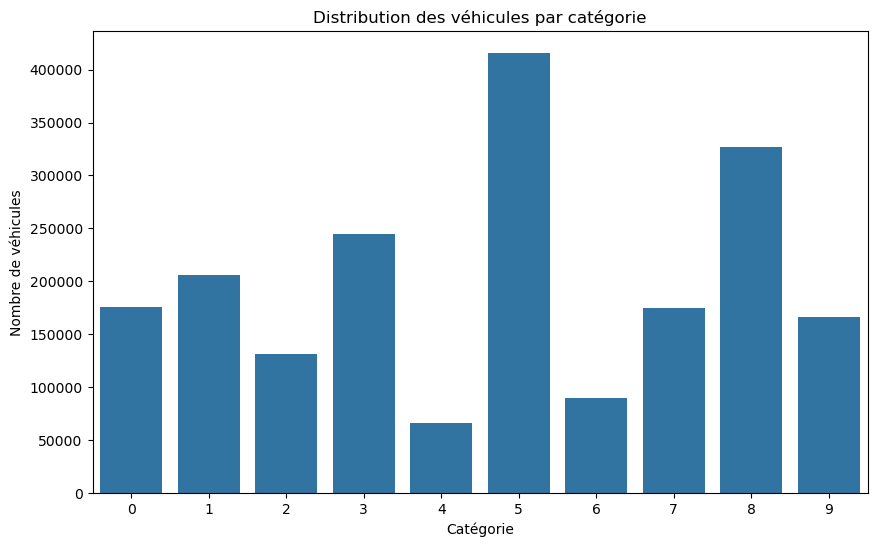

In [13]:
category_counts = result_df.groupBy("category").count().orderBy("category").collect()
categories = [row["category"] for row in category_counts]
counts = [row["count"] for row in category_counts]

plt.figure(figsize=(10, 6))
sns.barplot(x=categories, y=counts)
plt.xlabel("Catégorie")
plt.ylabel("Nombre de véhicules")
plt.title("Distribution des véhicules par catégorie")
plt.show()

In [14]:
cluster_summary = result_df.groupBy("category").agg(
    F.avg("puissance").alias("moy_puissance"),
    F.avg("longueur").alias("moy_longueur"),
    F.avg("nbPortes").alias("moy_nbPortes"),
    F.avg("prix").alias("moy_prix")
)
cluster_summary.show()


+--------+------------------+------------+------------+------------------+
|category|     moy_puissance|moy_longueur|moy_nbPortes|          moy_prix|
+--------+------------------+------------+------------+------------------+
|       1|  468.341157260945|         0.0|         5.0| 96050.16158111372|
|       6|             507.0|         0.0|         5.0|           66360.0|
|       3|270.99575371549895|         0.0|         5.0| 55367.04281874747|
|       5| 74.97275191242099|         0.0|         5.0|15184.805816455726|
|       9|187.94290447932042|         0.0|         5.0| 37389.05624002169|
|       4| 258.4073861404092|         0.0|         5.0|  34891.8785699175|
|       8|143.69026957842394|         0.0|         5.0|24228.071522181122|
|       7|  125.480437550312|         0.0|         5.0| 17318.56762789954|
|       2| 58.82969768008281|         0.0|         3.0|10981.459919016013|
|       0|188.41616260477184|         0.0|         5.0|28243.140907823534|
+--------+---------------

In [15]:
client_immatriculation_df = spark.sql("SELECT * FROM client_immatriculation_merged")


In [16]:
# Convertir les colonnes nécessaires en type numérique
client_immatriculation_df = client_immatriculation_df.withColumn("puissance", col("puissance").cast(DoubleType()))
client_immatriculation_df = client_immatriculation_df.withColumn("longueur", col("longueur").cast(DoubleType()))
client_immatriculation_df = client_immatriculation_df.withColumn("nbportes", col("nbportes").cast(DoubleType()))
client_immatriculation_df = client_immatriculation_df.withColumn("prix", col("prix").cast(DoubleType()))

# Remplacer les valeurs nulles par une valeur par défaut
client_immatriculation_df = client_immatriculation_df.fillna({
    "puissance": 0.0,
    "longueur": 0.0,
    "nbportes": 0.0,
    "prix": 0.0
})

In [17]:
# Assembler les caractéristiques dans un vecteur de caractéristiques
client_assembler = VectorAssembler(inputCols=["puissance", "longueur", "nbportes", "prix"], outputCol="features", handleInvalid="skip")
client_assembled_df = client_assembler.transform(client_immatriculation_df)

# Standardiser les caractéristiques
client_scaled_df = scaler_model.transform(client_assembled_df)

In [18]:
# Faire des prédictions pour les nouvelles données
client_clustered_df = model.transform(client_scaled_df)


In [19]:
# Supprimer la colonne 'scaled_features' car elle n'est plus nécessaire
drop_columns = ['scaled_features']
client_scaled_df = client_scaled_df.drop(*drop_columns)

In [20]:
client_labeled_df = client_clustered_df
client_labeled_df.select("marque", "modele", "puissance", "category").show(10)

+-------+------+---------+--------+
| marque|modele|puissance|category|
+-------+------+---------+--------+
|   Audi|    A2|     75.0|       5|
|   Ford|Mondeo|    125.0|       8|
|Renault|   Vel|    245.0|       4|
| Jaguar|X-Type|    197.0|       9|
| Jaguar|X-Type|    197.0|       9|
|  Volvo|   S80|    272.0|       3|
|   Audi|    A2|     75.0|       5|
|   Mini|Copper|    115.0|       7|
|   Ford|Mondeo|    125.0|       8|
|    BMW|    M5|    507.0|       1|
+-------+------+---------+--------+
only showing top 10 rows



In [21]:
client_category_counts = client_labeled_df.groupBy("category").count().orderBy("category").collect()
client_categories = [row["category"] for row in client_category_counts]
client_counts = [row["count"] for row in client_category_counts]

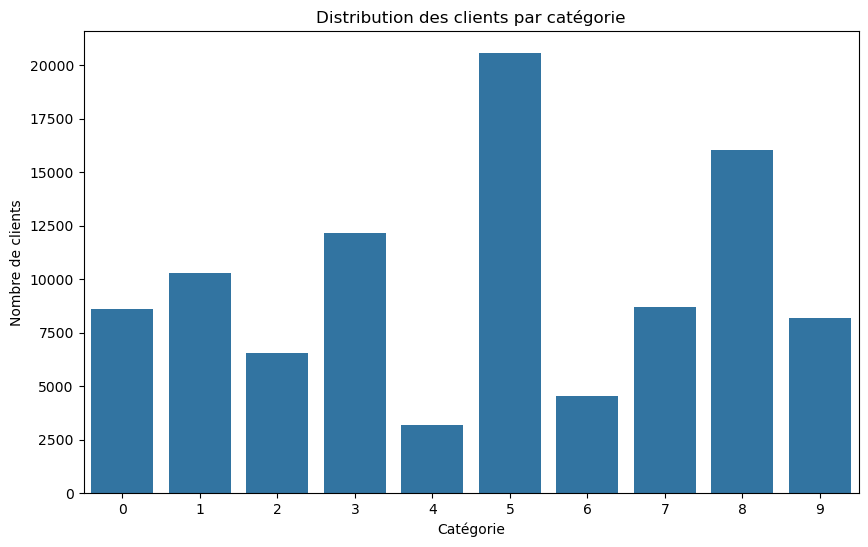

+-------+------+---------+--------+
| marque|modele|puissance|category|
+-------+------+---------+--------+
|   Audi|    A2|     75.0|       5|
|   Ford|Mondeo|    125.0|       8|
|Renault|   Vel|    245.0|       4|
| Jaguar|X-Type|    197.0|       9|
| Jaguar|X-Type|    197.0|       9|
|  Volvo|   S80|    272.0|       3|
|   Audi|    A2|     75.0|       5|
|   Mini|Copper|    115.0|       7|
|   Ford|Mondeo|    125.0|       8|
|    BMW|    M5|    507.0|       1|
+-------+------+---------+--------+
only showing top 10 rows



In [22]:
# Tracer la distribution des catégories dans 'client_labeled_df'
plt.figure(figsize=(10, 6))
sns.barplot(x=client_categories, y=client_counts)
plt.xlabel("Catégorie")
plt.ylabel("Nombre de clients")
plt.title("Distribution des clients par catégorie")
plt.show()
client_labeled_df.select("marque", "modele", "puissance", "category").show(10)

In [23]:
client_labeled_df.write.mode("overwrite").saveAsTable("client_immat_cat_1")

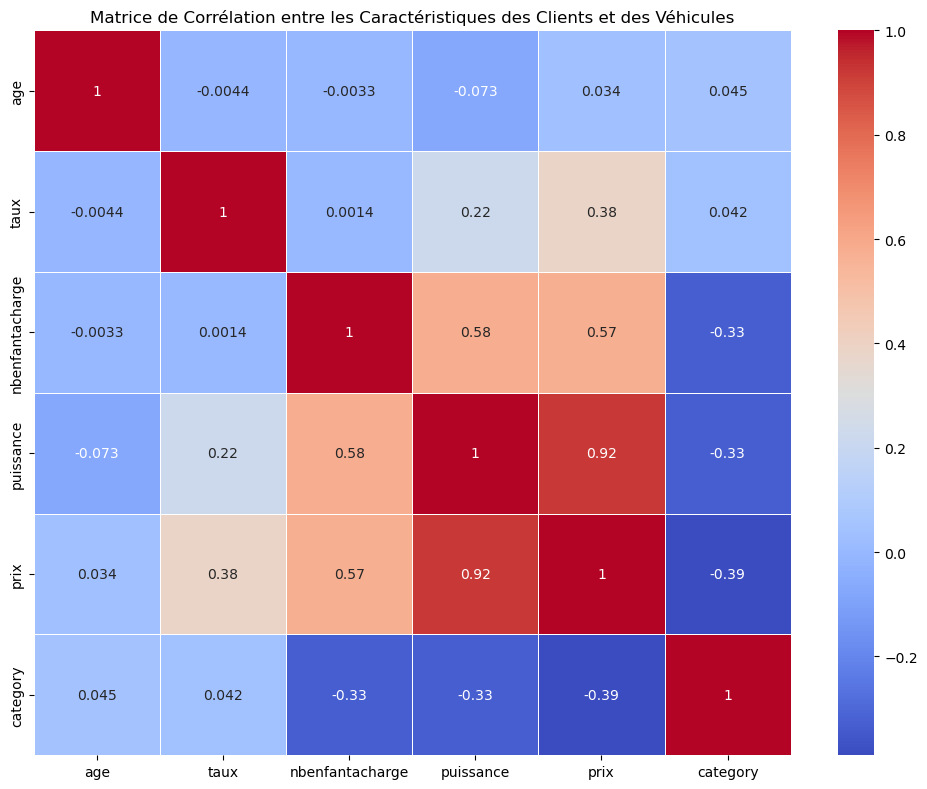

In [24]:
numerical_columns = ["age", "taux", "nbenfantacharge", "puissance", "prix", "category"]
numerical_df = client_labeled_df.select(numerical_columns)

numerical_df_pandas = numerical_df.toPandas()

# Calculer la matrice de corrélation
corr_matrix = numerical_df_pandas.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Matrice de Corrélation entre les Caractéristiques des Clients et des Véhicules")
plt.tight_layout()
plt.show()